**Assignment 6**
Applied Machine Learning 
In this assignment we will generate an ensemble of primitive classifiers, using Bagging method, and compare their performances to the regular classifiers. 

This week’s problem is the classification of heart failure disease. Download the Kaggle heart.csv dataset file from the module content. Load the dataset into your model development framework and examine the features to note that they are a mixture of numerical and nominal features. Apply necessary pre-processing such as nominal to numerical conversions (e.g. OneHotEncoder). Make sure to sanity check the pipeline and perhaps run your favorite baseline classifier first. 

In [1]:
## DATASET EXPLORATION
import numpy as np
import pandas as pd 
import seaborn as sns; 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (4,6)
sns.set(style="ticks", color_codes=True) 

## DATA PIPELINE
df = pd.read_csv("heart_dataset.csv")
print(f"Dataset Shape: {df.shape}")
print(f"Number of Duplicate Samples: {df.duplicated().sum()}")

sample = df.iloc[0]
dtypes = df.dtypes
nans = 100 * df.isna().sum() / len(df)
categories = df.nunique()
print(pd.concat(
    (sample, dtypes, nans, categories), 
    keys=["Sample", "Datatypes", "NaN %", "Num Categories"], 
    axis=1)
)

Dataset Shape: (918, 12)
Number of Duplicate Samples: 0
                Sample Datatypes  NaN %  Num Categories
Age                 40     int64    0.0              50
Sex                  M    object    0.0               2
ChestPainType      ATA    object    0.0               4
RestingBP          140     int64    0.0              67
Cholesterol        289     int64    0.0             222
FastingBS            0     int64    0.0               2
RestingECG      Normal    object    0.0               3
MaxHR              172     int64    0.0             119
ExerciseAngina       N    object    0.0               2
Oldpeak            0.0   float64    0.0              53
ST_Slope            Up    object    0.0               3
HeartDisease         0     int64    0.0               2


In [2]:
## RE-TYPE CATEGORICAL VARIABLES
numeric = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]
categorical = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope","HeartDisease"]
ordinal = [] # Note - ST_Slope may be ordinal, I am entirely sure how to treat it here. 
print("Categorical Variables:")
for feat in categorical: 
    print(f"{feat}: {set(df[feat])}")
    df[feat] = df[feat].astype('category')

Categorical Variables:
Sex: {'M', 'F'}
ChestPainType: {'NAP', 'ASY', 'TA', 'ATA'}
FastingBS: {0, 1}
RestingECG: {'ST', 'LVH', 'Normal'}
ExerciseAngina: {'Y', 'N'}
ST_Slope: {'Down', 'Up', 'Flat'}
HeartDisease: {0, 1}


                Sample Datatypes    Max   Min         Std
Age               40.0     int64   77.0  28.0    9.432617
Sex                1.0      int8    1.0   0.0    0.407701
ChestPainType      1.0      int8    3.0   0.0    0.956519
RestingBP        140.0     int64  200.0   0.0   18.514154
Cholesterol      289.0     int64  603.0   0.0  109.384145
FastingBS          0.0      int8    1.0   0.0    0.423046
RestingECG         1.0      int8    2.0   0.0    0.631671
MaxHR            172.0     int64  202.0  60.0   25.460334
ExerciseAngina     0.0      int8    1.0   0.0    0.490992
Oldpeak            0.0   float64    6.2  -2.6    1.066570
ST_Slope           2.0      int8    2.0   0.0    0.607056
HeartDisease       0.0      int8    1.0   0.0    0.497414


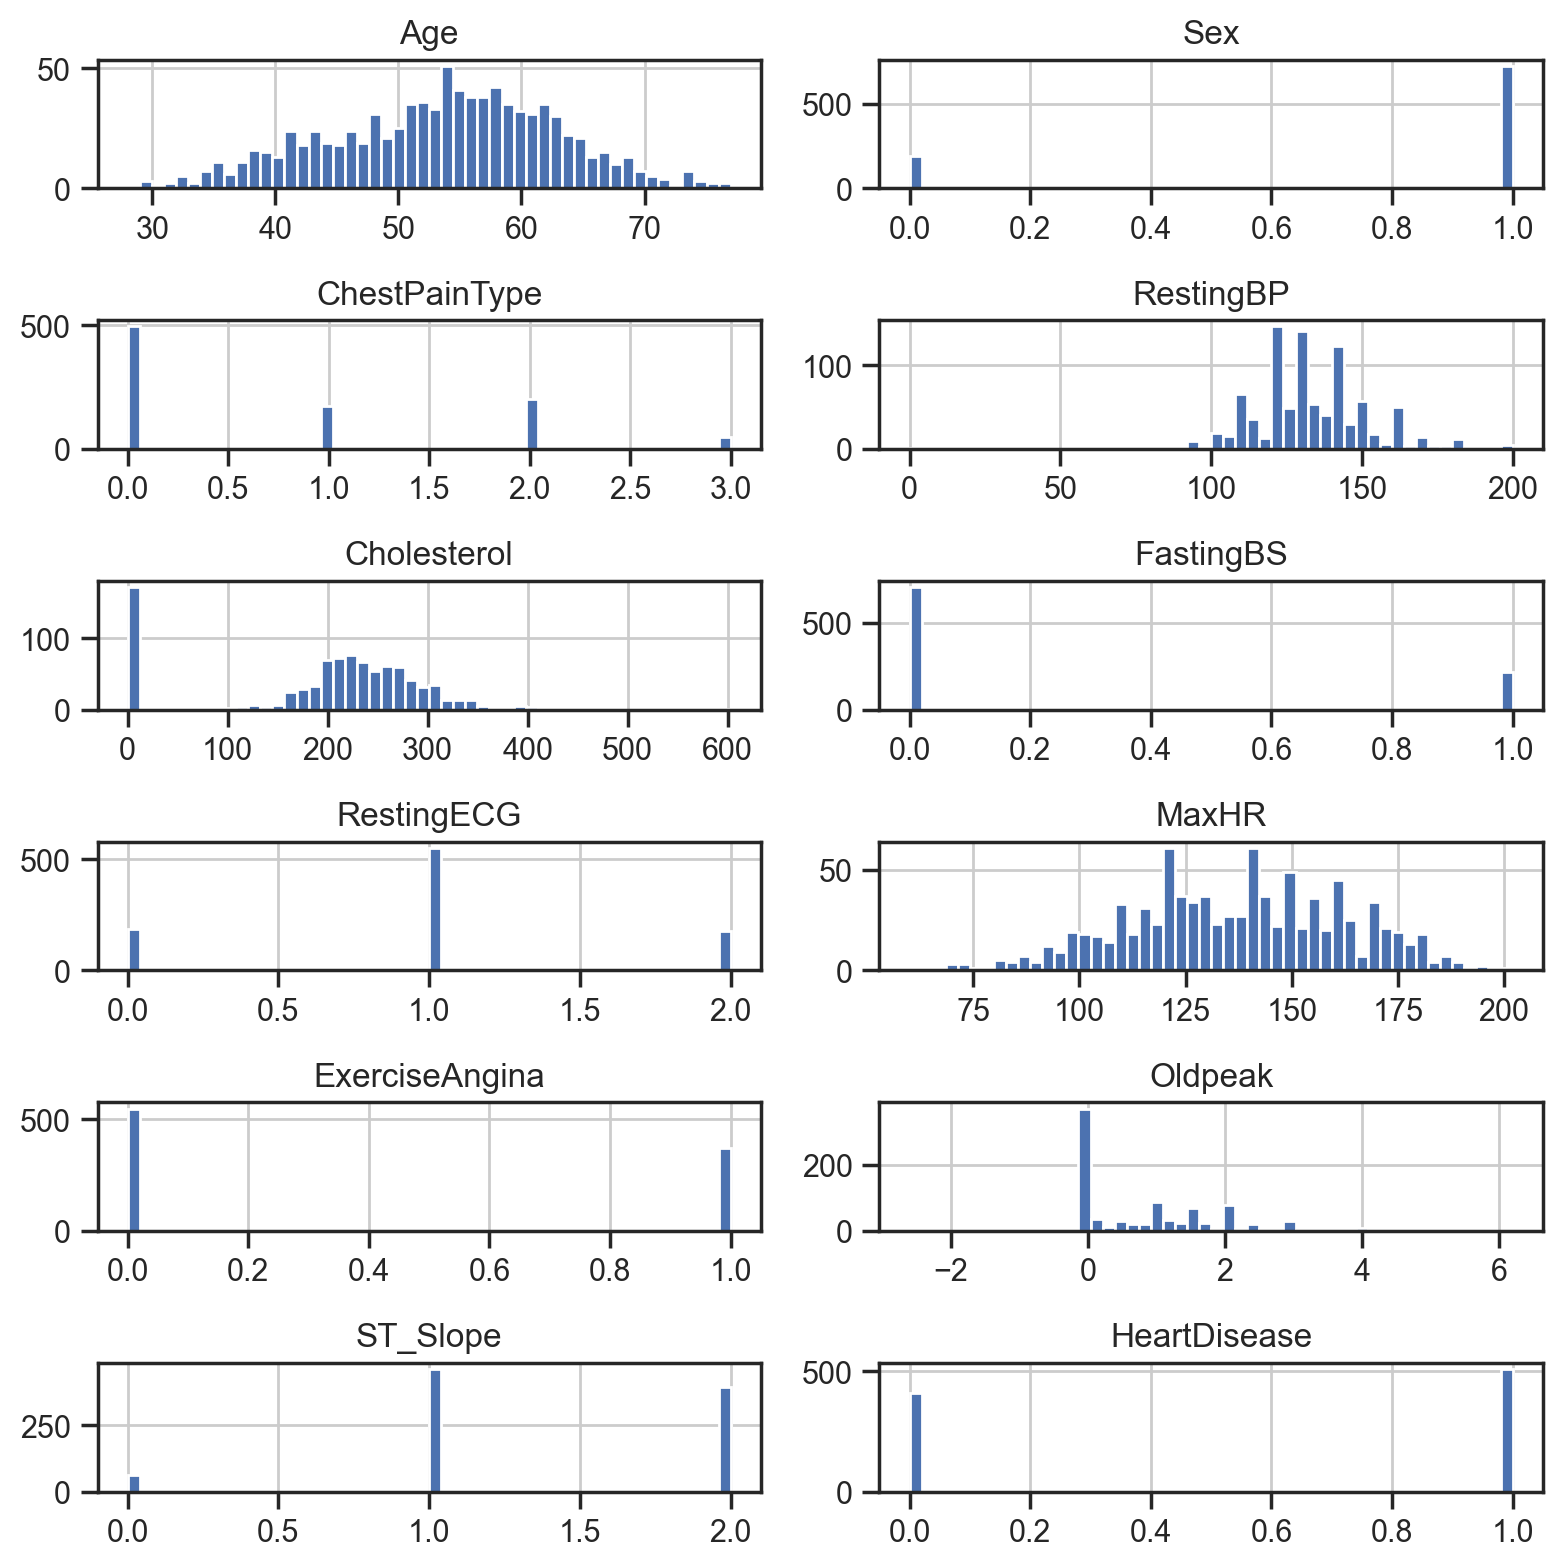

In [3]:
## CONVERT CATEGORICAL VARIABLES TO NUMERIC REPRESENTATIONS AND PLOT DISTRIBUTIONS
hist_df = df.copy()
hist_df[categorical] = hist_df[categorical].apply(lambda x: x.cat.codes)
print(pd.concat((hist_df.iloc[0], hist_df.dtypes, hist_df.max(), hist_df.min(), hist_df.std()), keys=["Sample", "Datatypes", "Max", "Min", "Std"], axis=1))
hist_df.hist(bins=50, figsize=(8,8), layout=(6,2))
plt.tight_layout()

NOTES:
It is impossible to have a cholesterol level of 0, so we have a large number of samples with invalid (or missing) cholesterol measurements. Since there are around 20% with a value of 0, these samples are subject to imputing. 

The minimum RestingBP should by 90 systolic, else the patient is in a life-threatening condition or dead. Since there are so few (2), these samples will be dropped. 

Oldpeak appears to be a feature which should take values greater than zero, but there are several samples that has values less than zero. Since there are so few (13), these samples will be dropped. 

Next I will get one-hot encodings to put all features into numerical format prior to using a KNN-imputer to fill in the invalid Cholesterol samples. 

Percentage of Invalid Samples:
Cholesterol: 0.187
Oldpeak: 0.014
RestingBP: 0.002


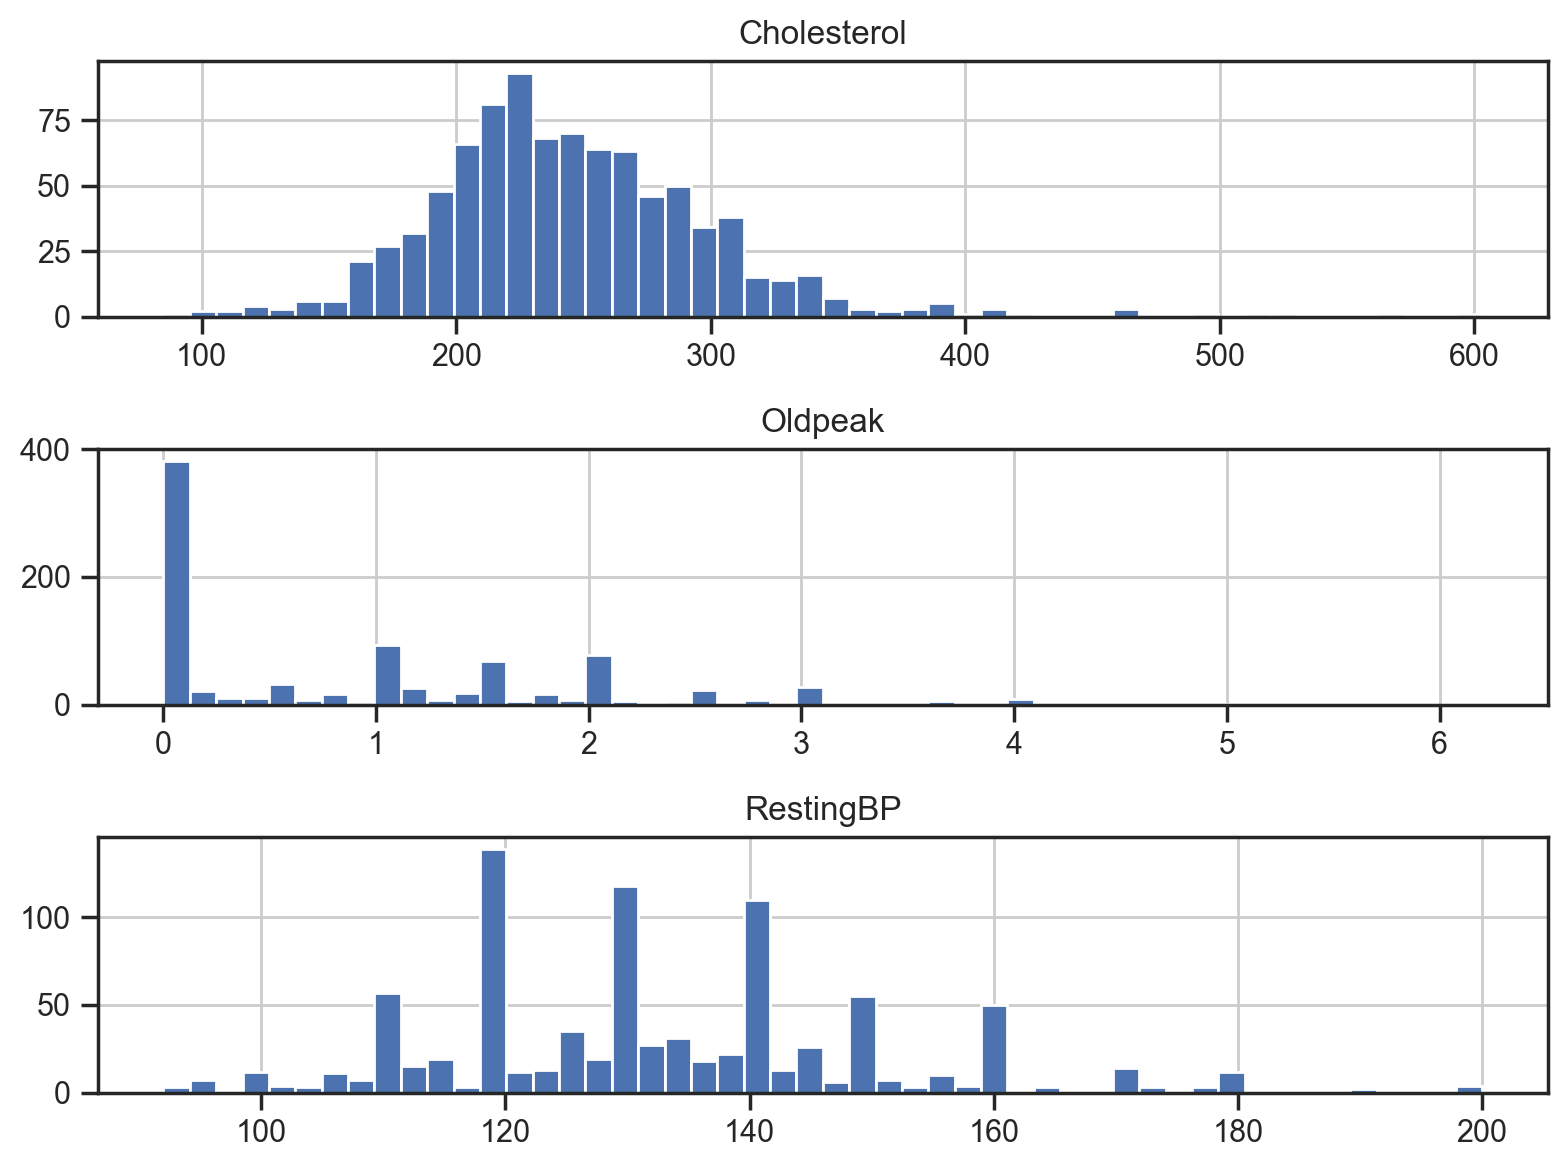

In [4]:

## REMOVE OUTLIERS AND INVALID ROWS
print("Percentage of Invalid Samples:")
print(f"Cholesterol: {sum(df.Cholesterol == 0) / len(df):.3f}")
print(f"Oldpeak: {sum(df.Oldpeak < 0) / len(df):.3f}")
print(f"RestingBP: {sum(df.RestingBP < 90) / len(df):.3f}")
df.drop(df[df.Oldpeak < 0].index, inplace=True)
df.drop(df[df.RestingBP < 90].index, inplace=True)

## ONE-HOT ENCODE CATEGORICALS
df = pd.get_dummies(df)

## IMPUTE VALUES FOR INVALID CHOLESTEROL SAMPLES
from sklearn.impute import KNNImputer
df.Cholesterol.replace(0, np.nan, inplace=True)
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df[["Cholesterol","Oldpeak","RestingBP"]].hist(bins=50, figsize=(8,6), layout=(3,1))
plt.tight_layout()

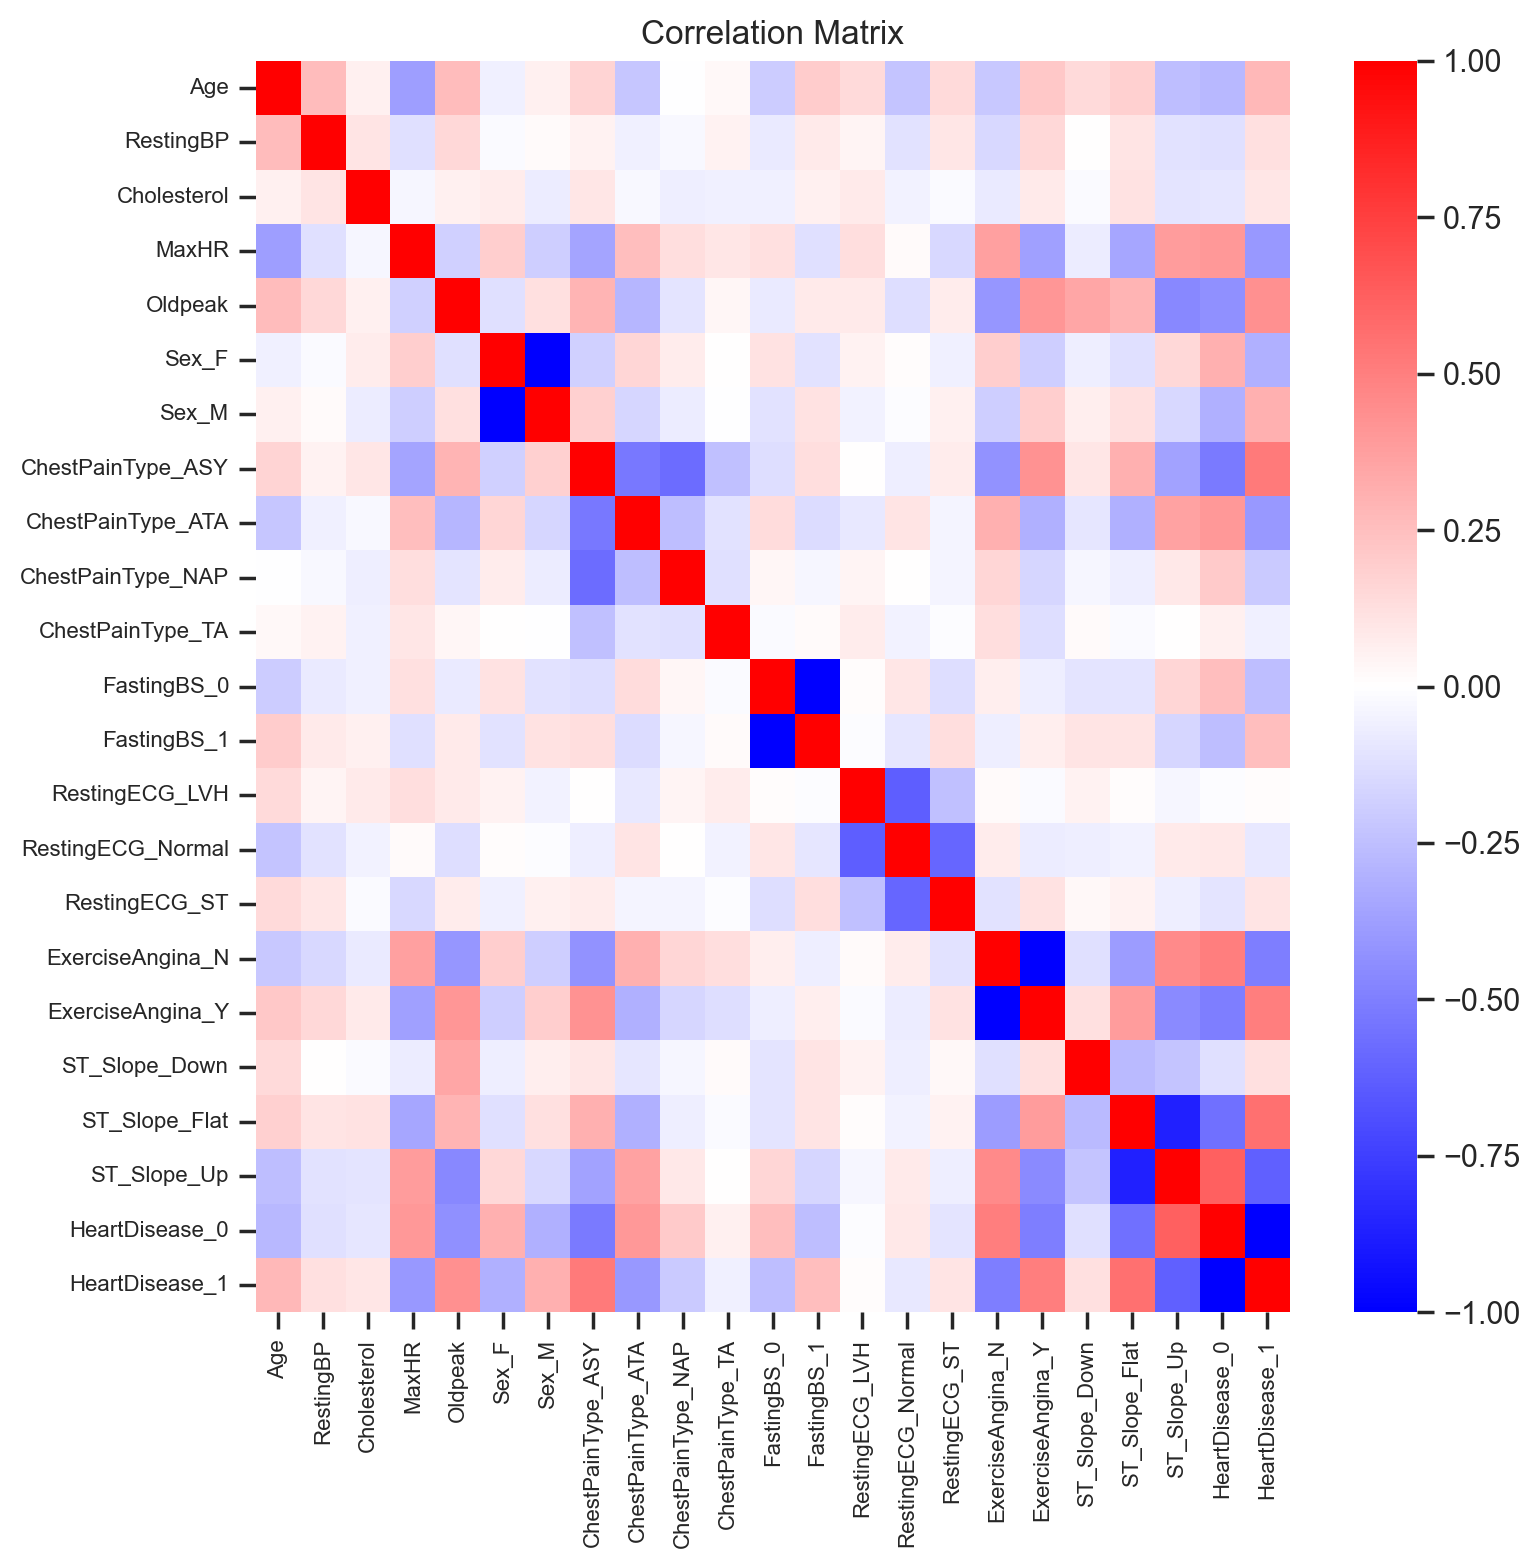

In [16]:
## EXAMINE CORRELATIONS BETWEEN FEATURES
plt.clf()
heatmap = sns.heatmap(df.corr(), cmap="bwr")
heatmap.set_title("Correlation Matrix")
heatmap.tick_params(axis='both', which='major', labelsize=8)
heatmap.tick_params(axis='both', which='minor', labelsize=8)
plt.rcParams["figure.figsize"] = (8,8)
plt.tight_layout()

1. [10 pts] Report 10-fold cross-validation (“CV”) performances of the following types of classifiers, using default parameters:  
• GaussianNB 
• Linear SVC (use SVC(kernel='linear', probability=True)) 
• MLPClassifier 
• DecisionTreeClassifier 
Now report the RandomForestClassifier performance too. Since this is already an ensemble classifier, this one does not need to be done with CV. 

In [6]:
## TRAIN MODEL
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
import numpy as np 


def train(X, y, model_class=None, model_config=None, model=None, k=10, shuffle=False, split=0.8):
    assert (model_class and model_config is not None) or model, \
        "Must provide an initialized model or a class and config"

    ## K-FOLD CROSS VALIDATION
    acc, conf = [], []
    if k > 1:
        kfold = KFold(n_splits=k, shuffle=shuffle)
        for i_train, i_test in kfold.split(X, y):
            
            ## TRAIN MODEL
            model = model_class(**model_config)
            model.fit(X[i_train], y[i_train])
            y_pred = model.predict(X[i_test])

            ## COMPUTE METRICS
            conf.append(metrics.confusion_matrix(y[i_test], y_pred))
            acc.append(metrics.accuracy_score(y[i_test], y_pred))

    ## SINGLE TRAIN-TEST SPLIT
    else:
        ## TRAIN MODEL
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=split)
        model = model or model_class(**model_config)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ## COMPUTE METRICS
        conf.append(metrics.confusion_matrix(y_test, y_pred))
        acc.append(metrics.accuracy_score(y_test, y_pred))

    ## REPORT METRICS
    conf = np.array(conf)
    tpr = conf[:, 0,0] / (conf[:, 0,0] + conf[:, 1,0] + 1e-10)
    fpr = conf[:, 0,1] / (conf[:, 0,0] + conf[:, 0,1] + 1e-10)
    print(f"{model.__class__.__name__} {k}-fold Mean Accuracy: {100*np.mean(acc):.4} ±{100*np.std(acc):.3}%")
    print(f"    Mean True Positive Rate: {100*np.mean(tpr):.4}%")
    print(f"    Mean False Positive Rate: {100*np.mean(fpr):.4}%\n")
    return acc, conf


## MIN-MAX NORMALIZE DATA
df_norm = (df - df.min()) / (df.max()-df.min())
X = df_norm.drop(columns=["HeartDisease_0","HeartDisease_1"]).values
y = df_norm["HeartDisease_1"].values

In [7]:
## NAIVE BAYES
model_config = {}
acc, conf = train(X, y, GaussianNB, model_config, k=10, shuffle=True)

## SVM
model_config = {"kernel":"linear", "probability":True}
acc, conf = train(X, y, SVC, model_config, k=10, shuffle=True)

## NEURAL NET
model_config = {"max_iter":750} ## To prevent convergence warning
acc, conf = train(X, y, MLPClassifier, model_config, k=10, shuffle=True)

## DECISION TREE
model_config = {}
acc, conf = train(X, y, DecisionTreeClassifier, model_config, k=10, shuffle=True)

## RANDOM FOREST
model_config = {}
acc, conf = train(X, y, RandomForestClassifier, model_config, k=1, shuffle=True)

GaussianNB 10-fold Mean Accuracy: 85.5 ±2.67%
    Mean True Positive Rate: 84.2%
    Mean False Positive Rate: 15.87%

SVC 10-fold Mean Accuracy: 86.15 ±2.9%
    Mean True Positive Rate: 85.82%
    Mean False Positive Rate: 17.72%

MLPClassifier 10-fold Mean Accuracy: 86.16 ±2.94%
    Mean True Positive Rate: 86.23%
    Mean False Positive Rate: 17.97%

DecisionTreeClassifier 10-fold Mean Accuracy: 77.41 ±2.82%
    Mean True Positive Rate: 74.01%
    Mean False Positive Rate: 23.08%

RandomForestClassifier 1-fold Mean Accuracy: 82.87 ±0.0%
    Mean True Positive Rate: 78.75%
    Mean False Positive Rate: 18.18%



2. [10 pts] Generate an ensemble of 100 classifiers for each of the four basic classifiers in Q1. and store each ensemble as a list. In order to create weak sub-classifiers within our ensembles, we underpower some hyperparameters:  
* For the neural network, set the hidden sizes to (3, 3), max iterations to 30, and tolerance to 1e-1. 
* For the decision tree, set max depth to 5 and max features to 5. 

For each of these 4 ensembles, report the performance of the first classifier in the ensemble. I.e., for your ensemble of 100 decision trees, report the performance of just the first weak tree. 

In [8]:
## NAIVE BAYES ENSEMBLE
model_config = {}
ensemble_nb = [GaussianNB(**model_config) for _ in range(100)]
acc, conf = train(X, y, model=ensemble_nb[0], k=1, shuffle=True)

## SVM ENSEMBLE
model_config = {"kernel":"linear", "probability":True}
ensemble_svm = [SVC(**model_config) for _ in range(100)]
acc, conf = train(X, y, model=ensemble_svm[0], k=1, shuffle=True)

## NEURAL NET ENSEMBLE
model_config = {"hidden_layer_sizes":(3,3), "max_iter":30, "tol":1e-1}
ensemble_nn = [MLPClassifier(**model_config) for _ in range(100)]
acc, conf = train(X, y, model=ensemble_nn[0], k=1, shuffle=True)

## DECISION TREE ENSEMBLE
model_config = {"max_depth":5, "max_features":5}
ensemble_dtree = [DecisionTreeClassifier(**model_config) for _ in range(100)]
acc, conf = train(X, y, model=ensemble_dtree[0], k=1, shuffle=True)

GaussianNB 1-fold Mean Accuracy: 82.87 ±0.0%
    Mean True Positive Rate: 80.43%
    Mean False Positive Rate: 14.94%

SVC 1-fold Mean Accuracy: 86.74 ±0.0%
    Mean True Positive Rate: 89.74%
    Mean False Positive Rate: 18.6%

MLPClassifier 1-fold Mean Accuracy: 83.43 ±0.0%
    Mean True Positive Rate: 76.32%
    Mean False Positive Rate: 17.14%

DecisionTreeClassifier 1-fold Mean Accuracy: 79.56 ±0.0%
    Mean True Positive Rate: 79.01%
    Mean False Positive Rate: 23.81%



3. [20 pts] Write a function ensemble_fit() to receive the ensemble (i.e. one of the 4 lists from Q2.) as an input and train it on one of the subsets (i.e. bagging) of the training data. (Hint: random.sample could generate the subset of data you’ll need.) This way, each classifier will see only a different subset of the training dataset, also called as subsampling the input data for training. Use all features in these subsamples; only subsample the rows/observations. 

In [9]:
import random

def ensemble_fit(X, y, ensemble:list, subsample_ratio=0.2):
    indices = list(np.arange(len(X)))
    k = max(int(len(X) * subsample_ratio), 1)
    for model in ensemble:
        ## TRAIN MODEL
        idx = stratified_sample(y, indices, k)
        model.fit(X[idx], y[idx])
    return ensemble

def stratified_sample(y, indices, k):
    ## RECURSIVE SAMPLE UNTIL BOTH CLASSES ARE PRESENT
    idx = random.sample(indices, k=k)
    if np.all(y[idx] == 0) or np.all(y[idx] == 1): 
        return stratified_sample(y, indices, k)
    return idx

4. [20 pts] Write a function ensemble_predict() to receive the trained ensemble (i.e. one of the lists from Q3.) as input and output a prediction for a given observation. Since each sub-classifier will have its own prediction, use a voting scheme on the returned predictions. 
(Hint: The final prediction should be the np.argmax() of the votes, not merely a “max”. Note that c.predict_proba() should have better results.) 

In [10]:
def ensemble_predict(X, ensemble:list):
    ## ASSUMING BINARY CLASSIFICATION
    votes = np.zeros((len(X), 2))
    for model in ensemble:
        vote = model.predict(X).astype(int)     # Binary prediction
        vote = np.stack((1-vote, vote), axis=1) # Separate columns for each class
        votes += vote                           # Add model vote to total per class
    return np.argmax(votes, axis=1)  

5. [20 pts] Report 10-fold CV performances of the ensembles with a subsample ratio of 0.2. Compare to a regular decision tree (same subsample ratio). Now repeat these for a subsample ratio of 0.05. 

In [11]:
def ensemble_train(X, y, model_class, model_config, n_estimators=100, k=10, shuffle=False, subsample_ratio=0.2, log=True):
    ## K-FOLD CROSS VALIDATION
    acc, conf = [], []
    kfold = KFold(n_splits=k, shuffle=shuffle)
    for i_train, i_test in kfold.split(X, y):
        ## TRAIN MODEL
        ensemble = [model_class(**model_config) for _ in range(n_estimators)]
        ensemble = ensemble_fit(X[i_train], y[i_train], ensemble, subsample_ratio)
        y_pred = ensemble_predict(X[i_test], ensemble)
        ## COMPUTE METRICS
        conf.append(metrics.confusion_matrix(y[i_test], y_pred))
        acc.append(metrics.accuracy_score(y[i_test], y_pred))

    ## REPORT METRICS
    conf = np.array(conf)
    if log:
        tpr = conf[:, 0,0] / (conf[:, 0,0] + conf[:, 1,0] + 1e-10)
        fpr = conf[:, 0,1] / (conf[:, 0,0] + conf[:, 0,1] + 1e-10)
        print(f"{ensemble[0].__class__.__name__} Ensemble SSR={subsample_ratio} Accuracy: {100*np.mean(acc):.4} ±{100*np.std(acc):.4}%")
        print(f"    True Positive Rate: {100*np.mean(tpr):.4}%")
        print(f"    False Positive Rate: {100*np.mean(fpr):.4}%\n")  
    return acc, conf


## NAIVE BAYES ENSEMBLE PREDICTION
counts = np.unique(y, return_counts=True)
model_config = {"priors":[counts[1][0]/len(y), counts[1][1]/len(y)]}
acc, conf = ensemble_train(X, y, GaussianNB, model_config, n_estimators=100, subsample_ratio=0.2)

## SVM ENSEMBLE PREDICTION
model_config = {"kernel":"linear", "probability":True}
acc, conf = ensemble_train(X, y, SVC, model_config, n_estimators=100, subsample_ratio=0.2)

## NEURAL NET ENSEMBLE PREDICTION
model_config = {"hidden_layer_sizes":(3,3), "max_iter":30, "tol":1e-1}
acc, conf = ensemble_train(X, y, MLPClassifier, model_config, n_estimators=100, subsample_ratio=0.2)

## DECISION TREE ENSEMBLE PREDICTION
model_config = {"max_depth":5, "max_features":5}
acc, conf = ensemble_train(X, y, DecisionTreeClassifier, model_config, n_estimators=100, subsample_ratio=0.2)

GaussianNB Ensemble SSR=0.2 Accuracy: 84.7 ±4.472%
    True Positive Rate: 79.09%
    False Positive Rate: 19.69%

SVC Ensemble SSR=0.2 Accuracy: 84.81 ±5.763%
    True Positive Rate: 81.55%
    False Positive Rate: 21.24%

MLPClassifier Ensemble SSR=0.2 Accuracy: 55.17 ±10.09%
    True Positive Rate: 44.89%
    False Positive Rate: 35.98%

DecisionTreeClassifier Ensemble SSR=0.2 Accuracy: 85.14 ±6.968%
    True Positive Rate: 80.41%
    False Positive Rate: 18.98%



In [12]:
## NAIVE BAYES ENSEMBLE PREDICTION
counts = np.unique(y, return_counts=True)
model_config = {"priors":[counts[1][0]/len(y), counts[1][1]/len(y)]}
acc, conf = ensemble_train(X, y, GaussianNB, model_config, n_estimators=100, subsample_ratio=0.05)

## SVM ENSEMBLE PREDICTION
model_config = {"kernel":"linear", "probability":True}
acc, conf = ensemble_train(X, y, SVC, model_config, n_estimators=100, subsample_ratio=0.05)

## NEURAL NET ENSEMBLE PREDICTION
model_config = {"hidden_layer_sizes":(3,3), "max_iter":30, "tol":1e-1}
acc, conf = ensemble_train(X, y, MLPClassifier, model_config, n_estimators=100, subsample_ratio=0.05)

## DECISION TREE ENSEMBLE PREDICTION
model_config = {"max_depth":5, "max_features":5}
acc, conf = ensemble_train(X, y, DecisionTreeClassifier, model_config, n_estimators=100, subsample_ratio=0.05)

GaussianNB Ensemble SSR=0.05 Accuracy: 83.82 ±4.88%
    True Positive Rate: 78.26%
    False Positive Rate: 21.58%

SVC Ensemble SSR=0.05 Accuracy: 84.69 ±6.173%
    True Positive Rate: 81.48%
    False Positive Rate: 22.31%

MLPClassifier Ensemble SSR=0.05 Accuracy: 59.17 ±16.95%
    True Positive Rate: 33.79%
    False Positive Rate: 78.45%

DecisionTreeClassifier Ensemble SSR=0.05 Accuracy: 84.25 ±6.544%
    True Positive Rate: 80.39%
    False Positive Rate: 21.94%



6. [10 pts] Report the 10-fold CV performances of the ensembles for the training subsample ratios of (0.005, 0.01, 0.03, 0.05, 0.1, 0.2). Now train regular versions of those 4 classifiers and report their performance. (Hint: pass the regular classifier to the same ensemble CV in a list of one element. This way, the same script can be used for this entire step) 

In [13]:
## SUBSAMPLE CROSS VALIDATION ON ENSEMBLES
ssr = (0.005, 0.01, 0.03, 0.05, 0.1, 0.2)
acc_ensemble_nb = []
acc_ensemble_svm = []
acc_ensemble_nn = []
acc_ensemble_dtree = []

for ratio in ssr:
    ## NAIVE BAYES ENSEMBLE PREDICTION
    counts = np.unique(y, return_counts=True)
    model_config = {"priors":[counts[1][0]/len(y), counts[1][1]/len(y)]}
    acc, conf = ensemble_train(X, y, GaussianNB, model_config, n_estimators=100, subsample_ratio=ratio, log=False)
    acc_ensemble_nb.append(np.mean(acc))

    ## SVM ENSEMBLE PREDICTION
    model_config = {"kernel":"linear", "probability":True}
    acc, conf = ensemble_train(X, y, SVC, model_config, n_estimators=100, subsample_ratio=ratio, log=False)
    acc_ensemble_svm.append(np.mean(acc))

    ## NEURAL NET ENSEMBLE PREDICTION
    model_config = {"hidden_layer_sizes":(3,3), "max_iter":30, "tol":1e-1}
    acc, conf = ensemble_train(X, y, MLPClassifier, model_config, n_estimators=100, subsample_ratio=ratio, log=False)
    acc_ensemble_nn.append(np.mean(acc))

    ## DECISION TREE ENSEMBLE PREDICTION
    model_config = {"max_depth":5, "max_features":5}
    acc, conf = ensemble_train(X, y, DecisionTreeClassifier, model_config, n_estimators=100, subsample_ratio=ratio, log=False)
    acc_ensemble_dtree.append(np.mean(acc))

print(f"Naive Bayes: {', '.join([str(round(i,2)) for i in acc_ensemble_nb])}")
print(f"Linear SVC: {', '.join([str(round(i,2)) for i in acc_ensemble_svm])}")
print(f"Nueral Net: {', '.join([str(round(i,2)) for i in acc_ensemble_nn])}")
print(f"Decision Tree: {', '.join([str(round(i,2)) for i in acc_ensemble_dtree])}")

Naive Bayes: 0.84, 0.85, 0.84, 0.84, 0.84, 0.85
Linear SVC: 0.86, 0.85, 0.85, 0.85, 0.84, 0.85
Nueral Net: 0.45, 0.45, 0.57, 0.51, 0.54, 0.62
Decision Tree: 0.83, 0.84, 0.85, 0.86, 0.85, 0.86


In [14]:
acc_nb = []
acc_svm = []
acc_nn = []
acc_dtree = []

for ratio in ssr:
    ## NAIVE BAYES ENSEMBLE PREDICTION
    counts = np.unique(y, return_counts=True)
    model_config = {"priors":[counts[1][0]/len(y), counts[1][1]/len(y)]}
    acc, conf = ensemble_train(X, y, GaussianNB, model_config, n_estimators=1, subsample_ratio=ratio, log=False)
    acc_nb.append(np.mean(acc))

    ## SVM ENSEMBLE PREDICTION
    model_config = {"kernel":"linear", "probability":True}
    acc, conf = ensemble_train(X, y, SVC, model_config, n_estimators=1, subsample_ratio=ratio, log=False)
    acc_svm.append(np.mean(acc))

    ## NEURAL NET ENSEMBLE PREDICTION
    model_config = {}
    acc, conf = ensemble_train(X, y, MLPClassifier, model_config, n_estimators=1, subsample_ratio=ratio, log=False)
    acc_nn.append(np.mean(acc))

    ## DECISION TREE ENSEMBLE PREDICTION
    model_config = {}
    acc, conf = ensemble_train(X, y, DecisionTreeClassifier, model_config, n_estimators=1, subsample_ratio=ratio, log=False)
    acc_dtree.append(np.mean(acc))

print(f"Naive Bayes: {', '.join([str(round(i,2)) for i in acc_nb])}")
print(f"Linear SVC: {', '.join([str(round(i,2)) for i in acc_svm])}")
print(f"Nueral Net: {', '.join([str(round(i,2)) for i in acc_nn])}")
print(f"Decision Tree: {', '.join([str(round(i,2)) for i in acc_dtree])}")

/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn

Naive Bayes: 0.52, 0.72, 0.74, 0.74, 0.77, 0.84
Linear SVC: 0.69, 0.79, 0.8, 0.8, 0.81, 0.83
Nueral Net: 0.69, 0.71, 0.82, 0.8, 0.83, 0.84
Decision Tree: 0.65, 0.69, 0.72, 0.73, 0.77, 0.77


/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


7. [10 pts] For each of the 4 types of classifier, plot the performances of the ensemble at the different subsample ratios and the performances of the regular classifier at the different subsample ratios on the same plot. Thus, you should have 4 plots, one for each type of classifier. To make it graphically clear which performances are ensemble vs. regular, plotting in 2 different colors is recommended. 

Report your detailed observations. 

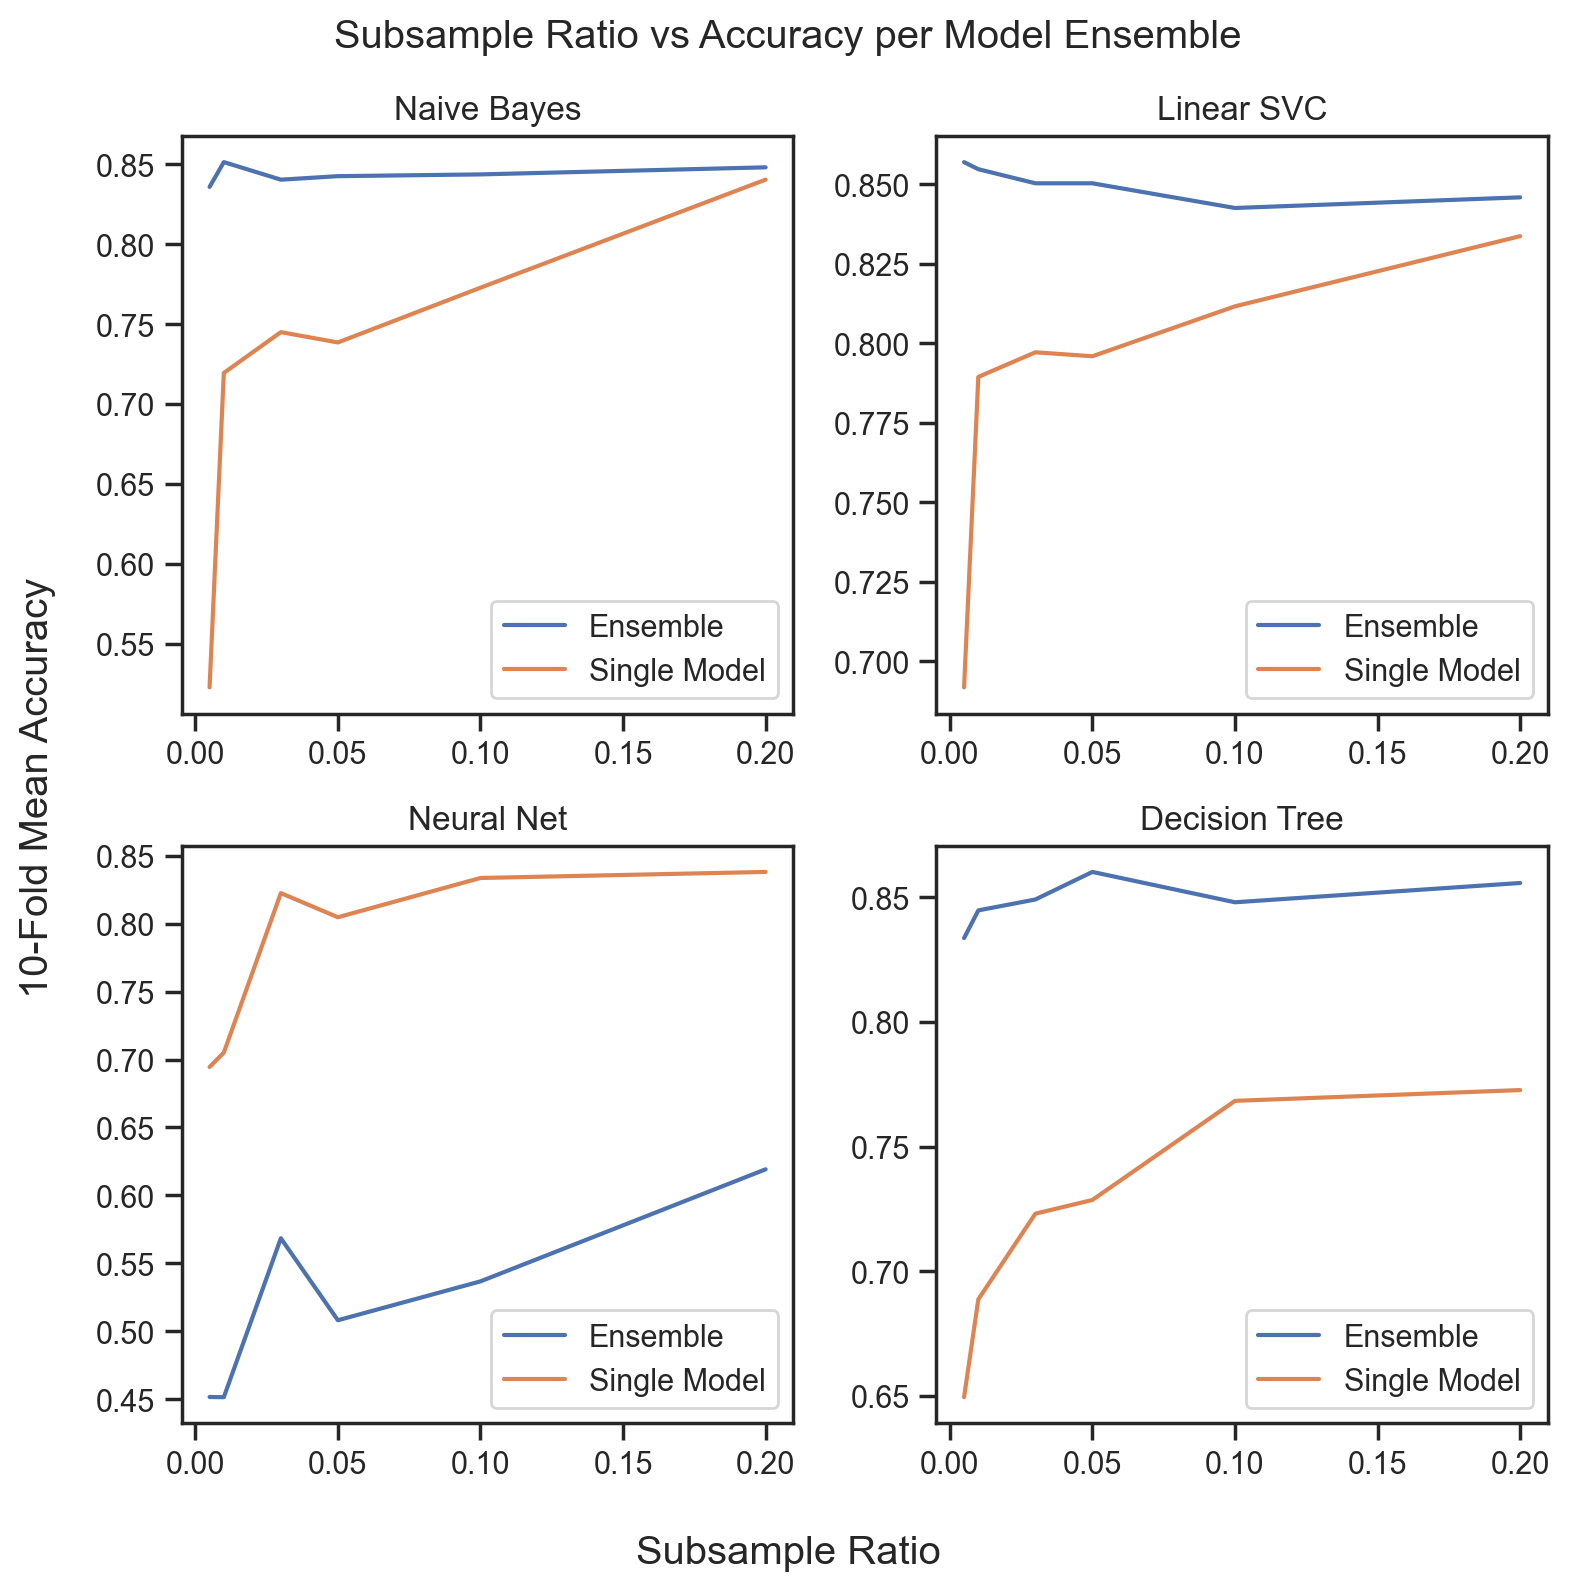

In [15]:

def plot(ax, ssr, ensemble, regular, title):
    ax.plot(ssr, ensemble, label="Ensemble")
    ax.plot(ssr, regular, label="Single Model")
    ax.legend()
    ax.set_title(title)
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
plot(axes[0,0], ssr, acc_ensemble_nb, acc_nb, "Naive Bayes")
plot(axes[0,1], ssr, acc_ensemble_svm, acc_svm, "Linear SVC")
plot(axes[1,0], ssr, acc_ensemble_nn, acc_nn, "Neural Net")
plot(axes[1,1], ssr, acc_ensemble_dtree, acc_dtree, "Decision Tree")

fig.suptitle("Subsample Ratio vs Accuracy per Model Ensemble")
fig.supxlabel("Subsample Ratio")
fig.supylabel("10-Fold Mean Accuracy")
plt.tight_layout()


In nearly all cases, the ensemble significantly outperforms the single regular model, with the gap between accuracy shrinking as the subsample ratio grows (i.e. as individual models get trained on a larger percentage of the dataset). 

One noteable departure from this trend is the neural network, whose single regular network performs significantly better than the ensemble. This is most likely due to the default hidden layer size of (100) and max iterations of 200 in the regular model. This enables the regular neural net to get many more gradient updates than the tiny ensemble networks. Additionally, a very wide network can act similarly to an ensemble of subnetworks, as a single wide layer can be viewed as many parallel subnetworks connected to the input and output layers. This means the regular network may be seeing the benefits of the ensemble without requiring an actual ensemble, plus the additional optimization steps. 

The Naive Bayes regular model nearly matches the performance of the ensemble at the highest subsample ratio, which is very similar to the graph we saw in the lecture notes. This makes sense, because as the regular model gets exposed to more of the data, it's likelihood estimates become significantly more accurate. It appears that voting allows the ensemble to overcome this problem, with the average appearing to capture the appropriate likelihoods of a sample for each class. 

With a very similar rationale, the regular linear SVM model improves significantly as it sees more data, coming very close to the performance of the ensemble when the  subsample ratio approaches 0.2. Interestingly, on this run the SVM ensemble performance seems to get marginally worse as the subsample ratio gets higher. I am not sure if this is just due to randomness of if something implicit in the design of the model would lead to this. 

Finally, the model with the biggest margin between ensemble and regular classifier is the decision tree. The single regular decision tree plateaus at a mean accuracy 10% below the average accuracy of the ensemble. It also narrowly has the highest average accuracy over all other approaches. These results support the rationale behind the Random Forest algorithm. 

Overall, for the majority of classifiers, using an ensemble greatly improves performance on this classification problem. 